# **Project**: Maze Rider

## Clemence GRISLAIN, Julien KHLAUT, Aubin TCHOI

**Expectation:**

For this project, we require you to do two things:
1. Answer the two questions that you will find below. These questions consist in implementing from scratch both a _Model free tabular RL agent_ and a _Deep Reinforcement Learning_ agent on a relatively simple maze environment.
2. Write a **short** report (2 pages maximum) on your findings, which algorithm worked best, what hyperparameters where key, what hyperparameters were useless.

The following requirements must be met for each projects:
- The deadline for the project is on Sunday 25th September. You should send us a mail with your project attached as a zip before sunday, midnight. Any additional day over the deadline will reduce the final grade by 2 points. Monday 00:01am counts as one day over the deadline.
- Projects should be done in groups of 5, and the following [spreadsheet](https://docs.google.com/spreadsheets/d/1YsgkQwBu1Y-A-y4Bf9JVpy0q4nqI4cOvQkS4LKjnLNg/edit?usp=sharing) should be filled to notify us of the groups.
- You can rely as much as you want on the previous practicals, including by copying chunks of code.
- You cannot share code with other groups. Any suspicion of code plagiarism will result in us halving the grade for both groups.

In [ ]:
# @title Installation
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!pip install imageio
!pip install gym

from IPython.display import clear_output

clear_output()

In [ ]:
# @title Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import time
import numpy as np
from gym import utils
import enum
from typing import *
import chex
import random

# Environment

For this project, our environment will be a maze. The idea is pretty simple: our agent starts at one end of the maze and must reach a certain goal at the other end. To make things spicier, the agent must also avoid pits scattered in the environment.

At each step the agent can perform one of this four actions: move to the left, to the right, up or down:
- If the agent reaches an empty cell, it gets a reward of $0$.
- If the agent tries to cross a wall, nothing happens and it also gets a reward of $0$.
- If the agent reaches the goal, the episode ends and it gets a reward of $1$.
- If the agent falls into a pit, the episode ends and it gets a reward of $-1$.

The walls will stay the same between each episode, however, the agent's starting position as well as the positions of the goal and the pits will be randomly picked between a small number of candidates at each episode.

In [ ]:
# @title **[Skip]** Environment implementation details

TXT_TEMPLATE = """
#######  #######
# SSS #  #PGGGP#
### ###  ##P P##
  # ######## #
  #          #
  ############
---
S=0
G=0
P=.5
"""


class CellType(enum.IntEnum):
    WALL = enum.auto()
    PLAYER = enum.auto()
    GOAL = enum.auto()
    PIT = enum.auto()
    EMPTY = enum.auto()


TYPE_TO_CHAR = {
    CellType.WALL: "#",
    CellType.PLAYER: "S",
    CellType.GOAL: "G",
    CellType.PIT: "P",
    CellType.EMPTY: " ",
}


def process_template(txt_template: str) -> Tuple[chex.Array, Mapping[str, float]]:
    char_to_type = {v: k for k, v in TYPE_TO_CHAR.items()}
    maze_template, maze_info = txt_template.split("---")
    grid = maze_template.split("\n")
    grid = [l for l in grid if l]
    n_lines, n_cols = len(grid), max(map(len, grid))
    grid = [l + " " * (n_cols - len(l)) for l in grid]
    grid = np.array(list(map(lambda x: list(x), grid)))
    mask_pattern = np.array([" "] * len(CellType))
    for k, v in TYPE_TO_CHAR.items():
        mask_pattern[k.value - 1] = v

    grid = grid[:, :, None] == mask_pattern[None, None]
    maze_infos = [
        list(map(lambda x: x.strip(" "), x.split("=")))
        for x in maze_info.split("\n")
        if x
    ]
    maze_infos = {char_to_type[k]: float(v) for k, v in maze_infos}
    return grid, maze_infos


def sample_grid(grid: chex.Array, maze_infos: Mapping[str, float]) -> chex.Array:
    sample = grid.copy()
    for k, v in maze_infos.items():
        layer = grid[..., k.value - 1]
        if v > 0.0:
            mask = np.random.binomial(1, v, size=layer.shape)
            sample[..., k.value - 1] = mask * layer
        else:
            idxs = np.nonzero(layer)
            i = np.random.randint(idxs[0].shape[0])
            sample[..., k.value - 1] = np.zeros_like(sample[..., k.value - 1])
            sample[..., k.value - 1][idxs[0][i], idxs[1][i]] = 1

    # For cells that have no values, fill the space layer with 1
    sample[..., CellType.EMPTY.value - 1] = np.maximum(
        np.all(sample == 0, axis=-1), sample[..., CellType.EMPTY.value - 1]
    )
    return sample


def to_string(grid: chex.Array) -> str:
    mask_pattern = np.array([" "] * len(CellType))
    for k, v in TYPE_TO_CHAR.items():
        mask_pattern[k.value - 1] = v
    str_grid = mask_pattern[grid.argmax(axis=-1)]
    str_grid = "\n".join(map(lambda x: "".join(x), str_grid))
    return str_grid

Read the following definition of the `Maze` environment, so that you get an idea of what you have access to in the environment.

In [ ]:
# @title **[Read]** Environment definition


class Maze:
    """
    Definition of the Maze environment.

    You do not need to read this class implementation in detail, you should
    just have a look at its different methods, to see what properties of the
    environment you can access.
    """

    def __init__(self, txt_template: str) -> None:
        self._grid_template, self._maze_infos = process_template(txt_template)

    def reset(self) -> chex.Array:
        """Resets the environment."""
        self._grid = sample_grid(self._grid_template, self._maze_infos)
        return self._grid

    def step(self, action: int) -> Tuple[chex.Array, float, bool]:
        """Perfoms one step in the environment.

        Args:
          action: index of the action to perform.
        Returns:
          next_state, reward, done

        next_state: next state of the environment.
        reward: reward of the current step.
        done: if True the game has ended.
        """
        n_rows, n_cols, _ = self._grid.shape
        x, y = np.nonzero(self._grid[..., CellType.PLAYER.value - 1])
        x, y = x[0], y[0]
        next_x, next_y = x, y
        if action == 0:
            next_x = max(min(x + 1, n_rows - 1), 0)
        elif action == 1:
            next_x = max(min(x - 1, n_rows - 1), 0)
        elif action == 2:
            next_y = max(min(y + 1, n_cols - 1), 0)
        elif action == 3:
            next_y = max(min(y - 1, n_cols - 1), 0)
        next_cell_type = CellType(self._grid[next_x, next_y].argmax() + 1)
        if next_cell_type is CellType.WALL:
            next_x, next_y = x, y
            reward = 0.0
            done = False
        elif next_cell_type is CellType.EMPTY:
            reward = 0.0
            done = False
        elif next_cell_type == CellType.PIT:
            reward = -1.0
            done = True
        elif next_cell_type == CellType.GOAL:
            reward = 1.0
            done = True
        else:
            raise ValueError(
                f"Unknown next cell type {next_cell_type}, this should not happen."
            )
        self._grid[..., CellType.PLAYER.value - 1][x, y] = 0
        self._grid[..., CellType.EMPTY.value - 1][x, y] = 1
        self._grid[..., :][next_x, next_y] = 0
        self._grid[..., CellType.PLAYER.value - 1][next_x, next_y] = 1
        return self._grid, reward, done

    def render(self) -> str:
        """Renders the environment as a string."""
        return to_string(self._grid)

    def num_actions(self) -> int:
        """Returns the number of usable actions."""
        return 4

    def obs_shape(self) -> Tuple[int, int]:
        """Returns the shape of the Maze."""
        return self._grid.shape

Use the following cell to interact manually with the environment: launch it and a small command line will appear. The commands **U**, **D**, **L** and **R** will move the agent `S`, try to reach the goal `G` by hand while avoiding the eventual pits `P`.

If, for some reason, you want to stop the episode before its end just enter **STOP** into the command line.

In [ ]:
# @title **[Play with the environment]**
env = Maze(TXT_TEMPLATE)

env.reset()

action_to_int = {
    "D": 0,
    "U": 1,
    "R": 2,
    "L": 3,
}

# To stop the game, enter this command
STOP_GAME = "STOP"

while True:
    print(env.render())
    while True:
        action = input().upper()
        if action in ["U", "D", "L", "R", STOP_GAME]:
            break
    if action == STOP_GAME:
        break
    _, reward, done = env.step(action_to_int[action])
    print(f"-----\nReward: {reward}\n-----\n")
    if done:
        break

#######  #######
#   S #  #P G  #
### ###  ##   ##
  # ######## #  
  #          #  
  ############  
STOP


In [ ]:
environment = Maze(TXT_TEMPLATE)
state = environment.reset()
print(state.shape)
print(state[:, :, 3])

(6, 16, 5)
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False  True
  False  True False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]


# **[Exercice 1]** Implementing a tabular RL Algorithm.

Your first task is to implement a model free tabular RL algorithm for the maze environment. You can go for either Q-learning or SARSA. Feel free to take inspiration from the other practicals.

## Hashing
As in the DQN practical, the environment state is a `chex.Array`, and it can thus not directly be put in a dictionary. As in this practical, you should implement a `numpy_to_hash` function.

This function should transform each state into something that can be used as a key in a dictionary. Additionally, this function should be invertible (each input is uniquely mapped to one unique output). In other word, this function should not lose any information. Think about all the information that are contained in a state (position of the agent, position of the goal, ...) and try to encode them in a hash in a compact way.

Contrary to what was done in the DQN practical, you do not need to implement a `hash_to_numpy` function that is the inverse of `np_to_hash`.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- `def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:` a function that takes in a transition and updates the agent policy.


In [ ]:
def np_to_hash(state: chex.Array) -> Tuple[int]:
    """Converts a state to a tuple of int."""
    s0, s1 = np.nonzero(state[:, :, 1])
    g0, g1 = np.nonzero(state[:, :, 2])
    p0, p1 = np.nonzero(state[:, :, 3])

    hashed = [s0[0], s1[0], g0[0], g1[0]]
    for i in range(len(p0)):
        hashed.append(p0[i])
        hashed.append(p1[i])

    return tuple(hashed)

In [ ]:
# @title **[Implement]** Define your agent
class Agent:
    """Q-learning with epsilon-greedy exploration."""

    def __init__(
        self,
        env: Maze,
        gamma: float,
        epsilon: float,
        alpha: float,
        hash_function: Callable[[chex.Array], Tuple[int]],
    ):
        self.qfunction = {}
        self._env = env
        self._epsilon = epsilon
        self._Na = env.num_actions()
        self._alpha = alpha
        self._gamma = gamma
        self.hash_function = hash_function

    def act(self, state: chex.Array, eval: bool = False) -> int:

        if not eval and np.random.uniform() < self._epsilon:
            return np.random.randint(self._Na)

        hashed_state = self.hash_function(state)

        if hashed_state not in self.qfunction:
            self.qfunction[hashed_state] = np.zeros(self._Na)

        return np.argmax(self.qfunction[hashed_state])

    def update(
        self,
        state: chex.Array,
        action: int,
        next_state: chex.Array,
        reward: float,
        done: bool,
    ) -> None:
        hashed_state = self.hash_function(state)
        if not done:
            hashed_next_state = self.hash_function(next_state)

        if hashed_state not in self.qfunction:
            self.qfunction[hashed_state] = np.zeros(self._Na)

        if not done and hashed_next_state not in self.qfunction:
            self.qfunction[hashed_next_state] = np.zeros(self._Na)

        if not done:
            self.qfunction[hashed_state][action] = (1 - self._alpha) * self.qfunction[
                hashed_state
            ][action] + self._alpha * (
                reward + self._gamma * self.qfunction[hashed_next_state].max()
            )
        else:
            self.qfunction[hashed_state][action] = (1 - self._alpha) * self.qfunction[
                hashed_state
            ][action] + self._alpha * (reward)

    def update_eps(self, lamdb: float) -> None:
        self._epsilon *= lamdb

    def update_alpha(self, lamdb: float) -> None:
        self._alpha *= lamdb

## Performance monitoring

A few utility function to monitor the runtime of each function.

In [ ]:
from functools import wraps
from time import perf_counter
from typing import Callable

In [ ]:
def timeit(func: Callable) -> Callable:
    """
    Decorator for timing function execution time.

    Usage:
        >>> @timeit
        >>> def my_function_to_time(*args, **kwargs):
        >>>     ...

    Args:
        func: The function to time.
    Returns:
        The wrapped function.
    """

    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = perf_counter()
        result = func(*args, **kwargs)
        end_time = perf_counter()
        total_time = end_time - start_time
        print(f"Function {func.__name__} took {total_time:.2f} seconds")
        return result

    return timeit_wrapper

In [ ]:
def checkpoint(time_ref: float = perf_counter()) -> Callable[..., None]:
    """
    Closure that stores a time checkpoint that is updated at every call.
    Each call prints the time elapsed since the last checkpoint with a custom message.
    Usage:
        >>> timer = checkpoint()
        >>> do_something()
        >>> timer("Time spent doing something")
        >>> do_something_else()
        >>> timer("Time spent doing something else")

    Args:
        time_ref: The time reference to start from. By default, the time of the call will be taken.
    Returns:
        The closure.
    """

    def _closure(message: str = "") -> None:
        """
        Prints the time elapsed since the previous call.

        Args:
            message: Custom message to print. The overall result will be: 'message: time_elapsed'.
        """
        nonlocal time_ref
        current_time = perf_counter()
        if message != "":
            print(f"{message}: {current_time - time_ref:.2f} seconds")
        time_ref = current_time

    return _closure

## Utility function to run the experiments

In [ ]:
def run_episode(
    agent: Agent, env: Maze, eval: bool, max_steps: int = 1000, render_env: bool = False
) -> float:
    # Reset any counts and start the environment.
    state = env.reset()
    n_steps = 0

    # Run an episode.
    while True:
        if render_env:
            print(f"Step: {n_steps}")
            print(env.render())

        # Generate an action from the agent's policy and step the environment.
        action = agent.act(state, eval=eval)
        next_state, reward, done = env.step(action)
        if not eval:
            agent.update(state, action, next_state, reward, done)
        n_steps += 1

        # early stopping strategy when the agent gets stuck during evaluation
        if eval and n_steps > 1 and (1.0 * state == 1.0 * next_state).all():
            break

        state = next_state.copy()
        if done or n_steps > max_steps:
            break

    return reward

In [ ]:
@timeit
def run_q_learning_experiment(
    alpha: float,
    epsilon: float,
    gamma: float,
    lambd: float,
    update_eps_every_N: int,
    mu: float = 1,
    update_alpha_every_N: int = 500,
    hash_function: Callable[[chex.Array], Tuple[int]] = np_to_hash,
    num_episodes: int = 2000,
    max_steps: int = 1000,
    maze_template: str = TXT_TEMPLATE,
) -> Tuple[Agent, Maze, List[float]]:

    num_eval_episodes = 10
    eval_every_N = 10

    environment = Maze(maze_template)
    Na = environment.num_actions

    agent = Agent(environment, gamma, epsilon, alpha, hash_function)
    all_rewards = []
    episodes = []

    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")

    for episode in range(num_episodes):
        try:
            run_episode(agent, environment, eval=False)

            if episode % eval_every_N == 0:
                reward = np.mean(
                    [
                        run_episode(agent, environment, eval=True)
                        for _ in range(num_eval_episodes)
                    ]
                )
                print(f"\t{episode}\t|\t{reward}")
                all_rewards.append(reward)
                episodes.append(episode)

            # updating epsilon
            if episode != 0 and episode % update_eps_every_N == 0:
                agent.update_eps(lambd)
                print(f"Updating epsilon to {agent._epsilon}")

            # updating alpha
            if episode != 0 and episode % update_alpha_every_N == 0:
                agent.update_alpha(mu)
                print(f"Updating alpha to {agent._alpha}")
        
        except KeyboardInterrupt:
          print("Stopping the experiment.")
          break

    plt.xlabel("Number of training episodes")
    plt.ylabel("Average return")
    plt.plot(episodes, all_rewards)

    return agent, environment, all_rewards

In [ ]:
@timeit
def validate_model(
    agent: Agent, env: Maze, max_steps: int = 1000, n_trials: int = 100
) -> Tuple[Agent, Maze, List[float]]:
    rewards = [
        run_episode(agent, env, eval=True, max_steps=max_steps)
        for _ in range(n_trials)
    ]
    print(
        f"Mean reward over {n_trials} trials: "
        f"{np.mean(rewards):.2f}, std: {np.std(rewards):.2f}"
    )

    return rewards

## Q-learning experiments

### Hyperparameters tuning

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
Updating epsilon to 0.63
	260	|	0.0
	270	|	0.1
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.1
	350	|	0.1
	360	|	0.0
	370	|	0.1
	380	|	0.1
	390	|	0.1
	400	|	0.2
	410	|	0.0
	420	|	0.1
	430	|	0.1
	440	|	0.2
	450	|	0.0
	460	|	0.0
	470	|	0.2
	480	|	0.2
	490	|	0.2
	500	|	0.1
Updating epsilon to 0.44099999999999995
Updating alpha to 0.05
	510	|	0.0
	520	|	0.2
	530	|	0.2
	540	|	0.1
	550	|	0.1
	560	|	0.4
	570	|	0.2
	580	|	0.0
	590	|	0.1
	600	|	0.1
	610	|	0.1
	620	|	0.4
	630	|	0.0
	640	|	0.3
	650	|	0.3
	660	|	0.1
	670	|	0.3
	680	|	0.4
	690	|	0.2
	700	|	0.1
	710	|	0.0
	720	|	0.3
	730	|	0.0


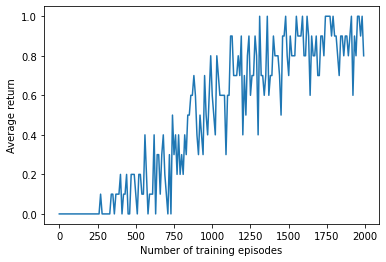

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.9, gamma=0.9, lambd=0.7, update_eps_every_N=250
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.0
	500	|	0.0
0.25
0.05
	510	|	0.0
	520	|	0.0
	530	|	0.1
	540	|	0.0
	550	|	0.0
	560	|	0.0
	570	|	0.0
	580	|	0.0
	590	|	0.1
	600	|	0.1
	610	|	0.0
	620	|	0.0
	630	|	0.0
	640	|	0.0
	650	|	0.0
	660	|	0.0
	670	|	0.1
	680	|	0.0
	690	|	0.0
	700	|	0.1
	710	|	0.0
	720	|	0.1
	730	|	0.3
	740	|	0.0
	750	|	0.1
	760	|	0.1
	770	|	0.0
	780	|	0.2
	790	|	0.2
	800	|	0.0
	

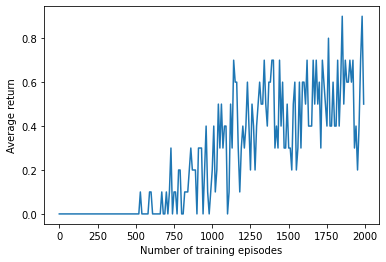

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.5, gamma=0.9, lambd=0.5, update_eps_every_N=500
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.1
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.2
	440	|	0.1
	450	|	0.2
	460	|	0.0
	470	|	0.1
	480	|	0.0
	490	|	0.0
	500	|	0.0
0.3
	510	|	0.0
	520	|	0.0
	530	|	0.1
	540	|	0.0
	550	|	0.0
	560	|	0.0
	570	|	0.0
	580	|	0.2
	590	|	0.1
	600	|	0.0
	610	|	0.0
	620	|	0.2
	630	|	0.0
	640	|	0.2
	650	|	0.2
	660	|	0.2
	670	|	0.2
	680	|	0.0
	690	|	0.1
	700	|	0.2
	710	|	0.0
	720	|	0.0
	730	|	0.2
	740	|	0.0
	750	|	0.2
	760	|	0.1
	770	|	0.1
	780	|	0.4
	790	|	0.5
	800	|	0.1
	810	|	

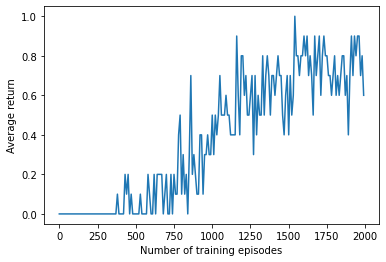

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.6, gamma=0.9, lambd=0.5, update_eps_every_N=500
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.1
	350	|	0.0
	360	|	0.0
	370	|	0.1
	380	|	0.1
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.1
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.1
	470	|	0.0
	480	|	0.0
	490	|	0.3
	500	|	0.2
0.35
	510	|	0.1
	520	|	0.1
	530	|	0.3
	540	|	0.0
	550	|	0.1
	560	|	0.3
	570	|	0.0
	580	|	0.1
	590	|	0.1
	600	|	0.3
	610	|	0.3
	620	|	0.2
	630	|	0.3
	640	|	0.1
	650	|	0.3
	660	|	0.6
	670	|	0.1
	680	|	0.3
	690	|	0.2
	700	|	0.1
	710	|	0.2
	720	|	0.3
	730	|	0.7
	740	|	0.5
	750	|	0.4
	760	|	0.3
	770	|	0.4
	780	|	0.2
	790	|	0.5
	800	|	0.6
	810	|

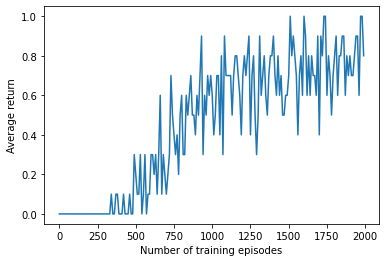

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.7, gamma=0.9, lambd=0.5, update_eps_every_N=500
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.1
	360	|	0.0
	370	|	0.1
	380	|	0.0
	390	|	0.1
	400	|	0.2
	410	|	0.2
	420	|	0.1
	430	|	0.0
	440	|	0.0
	450	|	0.1
	460	|	0.0
	470	|	0.1
	480	|	0.1
	490	|	0.1
	500	|	0.2
0.4
	510	|	0.2
	520	|	0.3
	530	|	0.3
	540	|	0.0
	550	|	0.1
	560	|	0.3
	570	|	0.2
	580	|	0.1
	590	|	0.3
	600	|	0.2
	610	|	0.0
	620	|	0.1
	630	|	0.3
	640	|	0.3
	650	|	0.5
	660	|	0.1
	670	|	0.3
	680	|	0.1
	690	|	0.3
	700	|	0.2
	710	|	0.2
	720	|	0.3
	730	|	0.7
	740	|	0.4
	750	|	0.5
	760	|	0.4
	770	|	0.2
	780	|	0.6
	790	|	0.4
	800	|	0.6
	810	|	

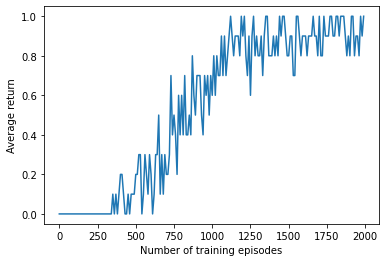

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.8, gamma=0.9, lambd=0.5, update_eps_every_N=500
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.1
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.1
	290	|	0.0
	300	|	0.0
	310	|	0.1
	320	|	0.1
	330	|	0.1
	340	|	0.1
	350	|	0.0
	360	|	0.0
	370	|	0.1
	380	|	0.0
	390	|	0.4
	400	|	0.3
	410	|	0.0
	420	|	0.0
	430	|	0.4
	440	|	0.3
	450	|	0.2
	460	|	0.3
	470	|	0.3
	480	|	0.2
	490	|	0.4
	500	|	0.3
0.45
	510	|	0.4
	520	|	0.2
	530	|	0.2
	540	|	0.3
	550	|	0.4
	560	|	0.3
	570	|	0.2
	580	|	0.4
	590	|	0.6
	600	|	0.8
	610	|	0.4
	620	|	0.3
	630	|	0.6
	640	|	0.2
	650	|	0.6
	660	|	0.5
	670	|	0.3
	680	|	0.2
	690	|	0.7
	700	|	0.8
	710	|	0.6
	720	|	0.4
	730	|	0.5
	740	|	0.6
	750	|	0.5
	760	|	0.6
	770	|	0.7
	780	|	0.5
	790	|	0.4
	800	|	0.7
	810	|

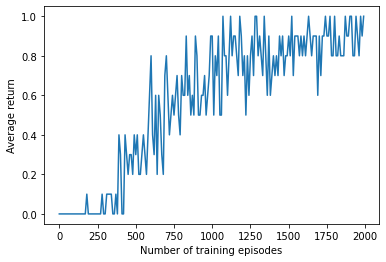

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.9, gamma=0.9, lambd=0.5, update_eps_every_N=500
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.1
	220	|	0.1
	230	|	0.1
	240	|	0.0
	250	|	0.1
0.675
	260	|	0.1
	270	|	0.2
	280	|	0.0
	290	|	0.1
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.2
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.3
	380	|	0.2
	390	|	0.3
	400	|	0.0
	410	|	0.1
	420	|	0.2
	430	|	0.1
	440	|	0.1
	450	|	0.1
	460	|	0.1
	470	|	0.2
	480	|	0.1
	490	|	0.3
	500	|	0.1
0.5062500000000001
	510	|	0.3
	520	|	0.1
	530	|	0.1
	540	|	0.3
	550	|	0.3
	560	|	0.1
	570	|	0.3
	580	|	0.2
	590	|	0.3
	600	|	0.1
	610	|	0.3
	620	|	0.2
	630	|	0.5
	640	|	0.2
	650	|	0.3
	660	|	0.2
	670	|	0.2
	680	|	0.1
	690	|	0.1
	700	|	0.3
	710	|	0.5
	720	|	0.2
	730	|	0.7
	740	|	0.3
	750	|	0.4
0.37968750000000007
	760	|	0.4
	770	|	0.6

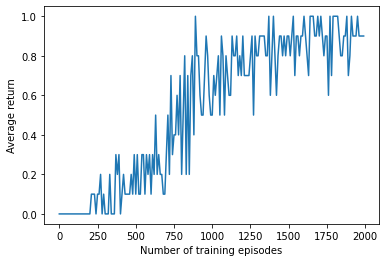

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05, epsilon=0.9, gamma=0.9, lambd=0.75, update_eps_every_N=250
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.2
	380	|	0.0
	390	|	0.1
	400	|	0.2
	410	|	0.2
	420	|	0.2
	430	|	0.0
	440	|	0.0
	450	|	0.1
	460	|	0.0
	470	|	0.3
	480	|	0.0
	490	|	0.1
	500	|	0.2
0.44099999999999995
	510	|	0.0
	520	|	0.4
	530	|	0.1
	540	|	0.3
	550	|	0.0
	560	|	0.0
	570	|	0.4
	580	|	0.3
	590	|	0.2
	600	|	0.2
	610	|	0.1
	620	|	0.3
	630	|	0.1
	640	|	0.4
	650	|	0.3
	660	|	0.4
	670	|	0.3
	680	|	0.3
	690	|	0.1
	700	|	0.0
	710	|	0.6
	720	|	0.2
	730	|	0.5
	740	|	0.5
	750	|	0.2
0.3086999999999999
	760	|	0.2
	770	|	0.4


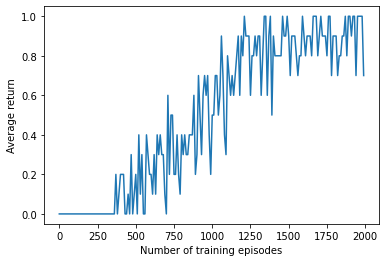

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.065, epsilon=0.9, gamma=0.9, lambd=0.7, update_eps_every_N=250
)
print(np.max(rewards))

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
0.765
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.65025
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
0.5527124999999999
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.1
	440	|	0.0
	450	|	0.0
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.1
	500	|	0.0
0.46980562499999995
0.05
	510	|	0.0
	520	|	0.0
	530	|	0.3
	540	|	0.2
	550	|	0.0
	560	|	0.1
	570	|	0.0
	580	|	0.2
	590	|	0.3
	600	|	0.3
	610	|	0.1
	620	|	0.0
0.39933478124999994
	630	|	0.1
	640	|	0.2
	650	|	0.1
	660	|	0.1
	670	|	0.1
	680	|	0.1
	690	|	0.2
	700	|	0.1
	710	|	0.4
	720	|	0.3
	730	|	0.2
	740	|	0.4

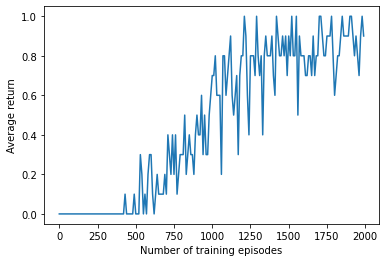

In [ ]:
run_q_learning_experiment(
    alpha=0.05, epsilon=0.9, gamma=0.9, lambd=0.85, update_eps_every_N=125
)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.1
	250	|	0.1
0.63
	260	|	0.0
	270	|	0.1
	280	|	0.1
	290	|	0.3
	300	|	0.1
	310	|	0.1
	320	|	0.2
	330	|	0.1
	340	|	0.1
	350	|	0.0
	360	|	0.1
	370	|	0.1
	380	|	0.1
	390	|	0.1
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.2
	450	|	0.1
	460	|	0.1
	470	|	0.4
	480	|	0.2
	490	|	0.1
	500	|	0.3
0.44099999999999995
0.07500000000000001
	510	|	0.2
	520	|	0.2
	530	|	0.2
	540	|	0.0
	550	|	0.2
	560	|	0.2
	570	|	0.2
	580	|	0.0
	590	|	0.1
	600	|	0.2
	610	|	0.1
	620	|	0.3
	630	|	0.1
	640	|	0.4
	650	|	0.3
	660	|	0.5
	670	|	0.2
	680	|	0.3
	690	|	0.4
	700	|	0.5
	710	|	0.1
	720	|	0.3
	730	|	0.3
	740	|	0.3
	750	|	0.2
0.3086999999999999
	7

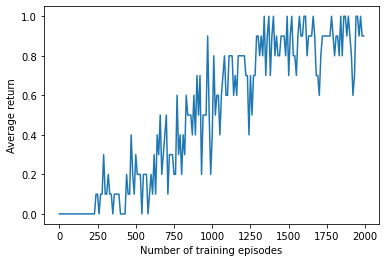

In [ ]:
run_q_learning_experiment(0.05, 0.9, 0.9, 0.7, 250, 1.5, 500)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.1
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.1
	370	|	0.0
	380	|	0.1
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.1
	440	|	0.0
	450	|	0.1
	460	|	0.2
	470	|	0.2
	480	|	0.1
	490	|	0.3
	500	|	0.0
0.44099999999999995
0.1
	510	|	0.4
	520	|	0.1
	530	|	0.2
	540	|	0.3
	550	|	0.2
	560	|	0.1
	570	|	0.1
	580	|	0.1
	590	|	0.3
	600	|	0.4
	610	|	0.4
	620	|	0.3
	630	|	0.5
	640	|	0.2
	650	|	0.5
	660	|	0.2
	670	|	0.4
	680	|	0.2
	690	|	0.5
	700	|	0.3
	710	|	0.6
	720	|	0.2
	730	|	0.4
	740	|	0.4
	750	|	0.1
0.3086999999999999
	760	|	0.7
	770	|	

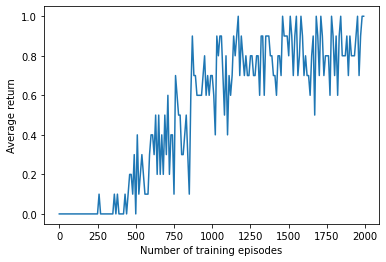

In [ ]:
run_q_learning_experiment(0.05, 0.9, 0.9, 0.7, 250, 2, 500)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.1
	200	|	0.0
	210	|	0.0
	220	|	0.1
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.1
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.2
	350	|	0.0
	360	|	0.1
	370	|	0.0
	380	|	0.0
	390	|	0.1
	400	|	0.0
	410	|	0.2
	420	|	0.0
	430	|	0.0
	440	|	0.1
	450	|	0.1
	460	|	0.0
	470	|	0.0
	480	|	0.1
	490	|	0.3
	500	|	0.1
0.44099999999999995
0.15000000000000002
	510	|	0.1
	520	|	0.3
	530	|	0.0
	540	|	0.1
	550	|	0.2
	560	|	0.3
	570	|	0.2
	580	|	0.2
	590	|	0.1
	600	|	0.2
	610	|	0.2
	620	|	0.4
	630	|	0.2
	640	|	0.4
	650	|	0.3
	660	|	0.5
	670	|	0.1
	680	|	0.1
	690	|	0.4
	700	|	0.6
	710	|	0.2
	720	|	0.4
	730	|	0.6
	740	|	0.5
	750	|	0.4
0.3086999999999999
	7

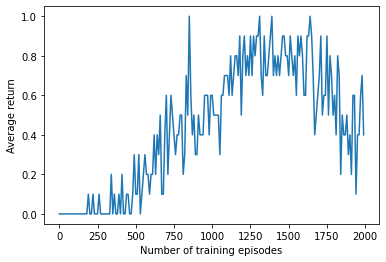

In [ ]:
run_q_learning_experiment(0.05, 0.9, 0.9, 0.7, 250, 3, 500)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.0
	270	|	0.1
	280	|	0.3
	290	|	0.0
	300	|	0.1
	310	|	0.0
	320	|	0.2
	330	|	0.1
	340	|	0.0
	350	|	0.1
	360	|	0.2
	370	|	0.1
	380	|	0.1
	390	|	0.1
	400	|	0.2
	410	|	0.3
	420	|	0.0
	430	|	0.0
	440	|	0.4
	450	|	0.1
	460	|	0.0
	470	|	0.1
	480	|	0.1
	490	|	0.2
	500	|	0.0
0.44099999999999995
0.037500000000000006
	510	|	0.2
	520	|	0.1
	530	|	0.1
	540	|	0.3
	550	|	0.1
	560	|	0.5
	570	|	0.4
	580	|	0.6
	590	|	0.2
	600	|	0.2
	610	|	0.5
	620	|	0.4
	630	|	0.3
	640	|	0.2
	650	|	0.3
	660	|	0.2
	670	|	0.3
	680	|	0.5
	690	|	0.2
	700	|	0.3
	710	|	0.3
	720	|	0.3
	730	|	0.4
	740	|	0.6
	750	|	0.6
0.3086999999999999
	

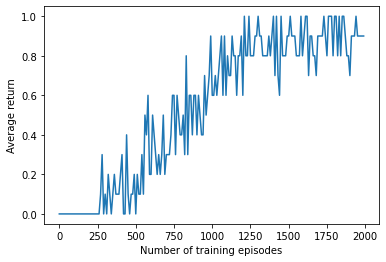

In [ ]:
run_q_learning_experiment(0.05, 0.9, 0.9, 0.7, 250, 0.75, 500)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.1
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
0.045000000000000005
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.3
	310	|	0.1
	320	|	0.1
	330	|	0.0
	340	|	0.1
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.1
	390	|	0.1
	400	|	0.0
	410	|	0.1
	420	|	0.1
	430	|	0.0
	440	|	0.2
	450	|	0.1
	460	|	0.2
	470	|	0.2
	480	|	0.2
	490	|	0.0
	500	|	0.1
0.44099999999999995
0.04050000000000001
	510	|	0.3
	520	|	0.2
	530	|	0.4
	540	|	0.1
	550	|	0.1
	560	|	0.2
	570	|	0.1
	580	|	0.4
	590	|	0.4
	600	|	0.2
	610	|	0.3
	620	|	0.2
	630	|	0.4
	640	|	0.0
	650	|	0.3
	660	|	0.2
	670	|	0.1
	680	|	0.5
	690	|	0.5
	700	|	0.4
	710	|	0.4
	720	|	0.6
	730	|	0.4
	740	|	0.4
	750	|	0.6


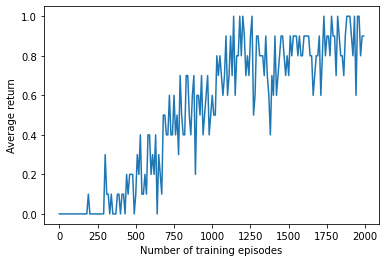

In [ ]:
run_q_learning_experiment(0.05, 0.9, 0.9, 0.7, 250, 0.9, 250)

## Additional experiment

This experiment involves an adaptative strategy to update $\epsilon$ and $\alpha$.
Rewards levels are defined for each of the two parameters and each time a reward level is reached, the corresponding parameter is updated.

In [ ]:
def run_adaptative_q_learning_experiment(
    alpha: float,
    epsilon: float,
    gamma: float,
    eps_reward_levels: List[float],
    eps_update_rates: List[float],
    alpha_rewards_levels: List[float],
    alpha_update_rates: List[float],
    n_levels_to_pass: int = 2,
    hashing_function: Callable[[chex.Array], Tuple[int]] = np_to_hash,
) -> List[float]:
    num_episodes = 2000
    num_eval_episodes = 10
    eval_every_N = 10

    environment = Maze(TXT_TEMPLATE)
    Na = environment.num_actions

    agent = Agent(environment, gamma, epsilon, alpha, hashing_function)
    all_rewards = []
    episodes = []

    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")

    eps_index, alpha_index = 0, 0
    eps_levels_passed, alpha_levels_passed = 0, 0
    for episode in range(num_episodes):
        run_episode(agent, environment, eval=False)

        if episode % eval_every_N == 0:
            reward = np.mean(
                [
                    run_episode(agent, environment, eval=True)
                    for _ in range(num_eval_episodes)
                ]
            )
            print(f"\t{episode}\t|\t{reward}")
            all_rewards.append(reward)
            episodes.append(episode)

            for i in range(eps_index, len(eps_reward_levels)):
                if reward >= eps_reward_levels[i]:
                    eps_levels_passed += 1
                    if eps_levels_passed == n_levels_to_pass:
                        eps_index = i + 1
                        eps_levels_passed = 0
                        agent.update_eps(eps_update_rates[i] / agent._epsilon)
                        print(f"Upding epsilon to {agent._epsilon}")

            for i in range(alpha_index, len(alpha_rewards_levels)):
                if reward >= alpha_rewards_levels[i]:
                    alpha_levels_passed += 1
                    if alpha_levels_passed == n_levels_to_pass:
                        alpha_index = i + 1
                        alpha_levels_passed = 0
                        agent.update_eps(alpha_update_rates[i] / agent._alpha)
                        print(f"Updating alpha to {agent._alpha}")

    plt.xlabel("Number of training episodes")
    plt.ylabel("Average return")
    plt.plot(episodes, all_rewards)

    return all_rewards

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.1
	330	|	0.1
change epsilon to  0.6
	340	|	0.1
	350	|	0.1
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.1
	410	|	0.0
	420	|	0.2
	430	|	0.0
	440	|	0.0
	450	|	0.2
	460	|	0.1
	470	|	0.1
	480	|	0.2
	490	|	0.2
	500	|	0.3
	510	|	0.1
	520	|	0.2
	530	|	0.1
	540	|	0.2
	550	|	0.5
change epsilon to  0.4
	560	|	0.3
	570	|	0.4
	580	|	0.0
	590	|	0.0
	600	|	0.4
	610	|	0.3
	620	|	0.3
	630	|	0.3
	640	|	0.5
change epsilon to  0.3
	650	|	0.3
	660	|	0.4
	670	|	0.3
	680	|	0.6
	690	|	0.3
	700	|	0.6
	710	|	0.6
	720	|	0.4
	730	|	0.2
	740	|	0.4
	750	|	0

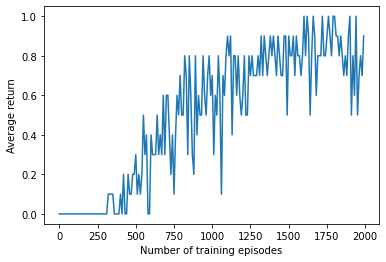

In [ ]:
rewards = run_adaptative_q_learning_experiment(
    alpha=0.05,
    epsilon=0.9,
    gamma=0.9,
    eps_reward_levels=[0.1, 0.3, 0.5, 0.7, 0.9, 1, 1],
    eps_update_rates=[0.6, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01],
    alpha_reward_levels=[0.7, 1],
    alpha_update_rates=[0.035, 0.025],
)

## Final run with the optimal parameters

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.1
	230	|	0.2
	240	|	0.0
	250	|	0.0
Updating epsilon to 0.63
	260	|	0.0
	270	|	0.0
	280	|	0.1
	290	|	0.2
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.1
	340	|	0.1
	350	|	0.0
	360	|	0.1
	370	|	0.0
	380	|	0.1
	390	|	0.3
	400	|	0.2
	410	|	0.1
	420	|	0.0
	430	|	0.1
	440	|	0.2
	450	|	0.1
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.1
	500	|	0.2
Updating epsilon to 0.44099999999999995
Updating alpha to 0.05
	510	|	0.0
	520	|	0.0
	530	|	0.2
	540	|	0.2
	550	|	0.0
	560	|	0.1
	570	|	0.1
	580	|	0.1
	590	|	0.3
	600	|	0.3
	610	|	0.4
	620	|	0.4
	630	|	0.1
	640	|	0.1
	650	|	0.1
	660	|	0.2
	670	|	0.2
	680	|	0.0
	690	|	0.1
	700	|	0.4
	710	|	0.2
	720	|	0.2
	730	|	0.3


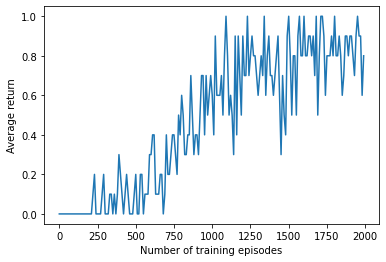

In [ ]:
%%time

optimal_parameters_small_maze = {
    "alpha": 0.05,
    "epsilon": 0.9,
    "gamma": 0.9,
    "lambd": 0.7,
    "update_eps_every_N": 250,
    "update_alpha_every_N": 500
}

agent_sm, environment_sm, rewards_sm = run_q_learning_experiment(
    **optimal_parameters_small_maze
)

In [ ]:
rewards_sm = validate_model(agent_sm, environment_sm)


Mean reward over 100 trials: 0.89, std: 0.21
Function validate_model took 0.13 seconds



## Experiments on the big maze

In [ ]:
BIG_MAZE = """
#########################################
#SSS#     #PPP#S#      #         #G   PP#
#   #GP       # #####  #P  #     #      #
#   ####  #   # #G     #   #GGGGGGGGG   #
#      GGG#   # #      #   ###########  #
###########         #      #            #
#G        #PP     GGGGGG#GG###S      GGG#
#PP  P#   ##################    #########
#######   #      #P                     #
#G               G      #S      P#      #
#########################################
---
S=0
G=0
P=0.5
"""

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.0
	500	|	0.0
	510	|	0.0
	520	|	0.0
	530	|	0.0
	540	|	0.0
	550	|	0.0
	560	|	0.0
	570	|	0.0
	580	|	0.0
	590	|	0.0
	600	|	0.0
	610	|	0.0
	620	|	0.0
	630	|	0.0
	640	|	0.0
	650	|	0.0
	660	|	0.0
	670	|	0.0
	680	|	0.0
	690	|	0.0
	700	|	0.0
	710	|	0.0
	720	|	0.0
	730	|	0.0
	740	|	0.0
	750	|	0.0
	760	|	0.0
	770	|	0.0
	780	|	0.0
	790	|	0.0
	800	|	0.0
	810	|	0.0


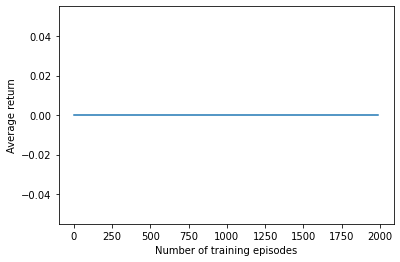

In [ ]:
# @title Trying out the model without any change

agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05,
    epsilon=0.9,
    gamma=0.9,
    lambd=0.9,
    update_eps_every_N=2000,
    mu=1,
    update_alpha_every_N=1000,
    maze_template=BIG_MAZE,
)

We observe that the current implementation does not seem efficient on the bigger maze as is.

### Updating the hash function

The hash function below is designed to lower the number of possible states by forgetting about the actual pits and only showing the spots containing potential pits. This way, two different draws of the locations of the pits will resolve to the same states.

This approach comes with its drawbacks, mainly residing in the fact that the agent will not have access to the information of the actual pits and will have to learn that he will not inevitably lose when walking on a pit but only with a certain probability.

What we wanted to find out with this experiment is to understand whether the issue comes from the number of states or from some other factor in play here.

In [ ]:
def np_to_hash_with_potential_pits(state: chex.Array) -> Tuple[int]:
    """
    Converts a state to a tuple of int.
    """
    s0, s1 = np.nonzero(state[:, :, 1])
    g0, g1 = np.nonzero(state[:, :, 2])
    p0, p1 = np.nonzero(process_template(BIG_MAZE)[0][:, :, 3])

    hashed = [s0[0], s1[0], g0[0], g1[0]]
    for i in range(len(p0)):
        hashed.append(p0[i])
        hashed.append(p1[i])

    return tuple(hashed)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.1
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.1
	380	|	0.0
	390	|	0.1
	400	|	0.1
	410	|	0.0
	420	|	0.1
	430	|	0.0
	440	|	0.0
	450	|	0.1
	460	|	0.2
	470	|	0.0
	480	|	0.2
	490	|	0.1
	500	|	0.1
0.44099999999999995
	510	|	0.0
	520	|	0.1
	530	|	0.1
	540	|	0.1
	550	|	0.0
	560	|	0.0
	570	|	0.0
	580	|	0.0
	590	|	0.0
	600	|	0.2
	610	|	0.1
	620	|	0.1
	630	|	0.0
	640	|	0.1
	650	|	0.0
	660	|	0.0
	670	|	0.1
	680	|	0.0
	690	|	0.2
	700	|	0.1
	710	|	0.0
	720	|	0.0
	730	|	0.1
	740	|	0.1
	750	|	0.0
0.3086999999999999
	760	|	0.1
	770	|	0.0


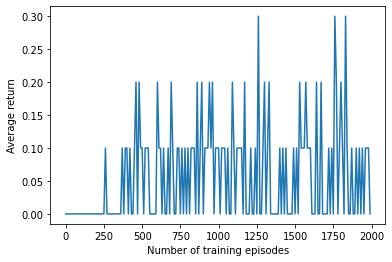

In [ ]:
agent, environment, rewards = run_q_learning_experiment(
    alpha=0.05,
    epsilon=0.9,
    gamma=0.9,
    lambd=0.7,
    update_eps_every_N=250,
    mu=1,
    update_alpha_every_N=1000,
    hash_function=np_to_hash_with_potential_pits,
)

In [ ]:
def print_agent_n_learned_states(agent: Agent) -> None:
    """
    Prints the number of states where the Q-function learnt by the agent is nonzero.
    """
    learned_states = sum(
        1 * np.any(agent.qfunction[key]) for key in agent.qfunction.keys()
    )

    print(f"Number of states where the learned Q-function is nonzero: {learned_states}")
    print(
        f"Number of possible states:                                {len(agent.qfunction.keys())}"
    )

In [ ]:
print_agent_n_learned_states(agent)

Number of states where the learned Q-function is nonzero: 388
Number of possible states:                                4829


Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.1
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.1
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.1
	180	|	0.2
	190	|	0.1
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
0.63
	260	|	0.1
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.1
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.2
	370	|	0.1
	380	|	0.1
	390	|	0.0
	400	|	0.1
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.3
	450	|	0.2
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.1
	500	|	0.1
0.44099999999999995
	510	|	0.0
	520	|	0.1
	530	|	0.0
	540	|	0.1
	550	|	0.1
	560	|	0.2
	570	|	0.1
	580	|	0.0
	590	|	0.0
	600	|	0.0
	610	|	0.0
	620	|	0.1
	630	|	0.0
	640	|	0.1
	650	|	0.0
	660	|	0.0
	670	|	0.1
	680	|	0.0
	690	|	0.4
	700	|	0.0
	710	|	0.0
	720	|	0.1
	730	|	0.0
	740	|	0.0
	750	|	0.1
0.3086999999999999
	760	|	0.1
	770	|	0.0


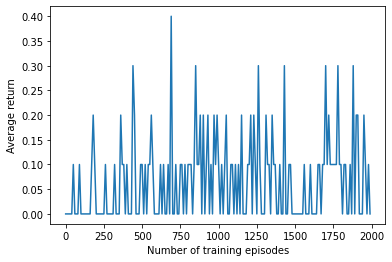

In [ ]:
run_q_learning_experiment(
    0.05, 0.9, 0.9, 0.7, 250, 1, 1000, np_to_hash_with_potential_pits, 2000, 2000
)

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.1
	180	|	0.1
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.1
	260	|	0.0
	270	|	0.0
	280	|	0.1
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.1
	340	|	0.0
	350	|	0.1
	360	|	0.1
	370	|	0.1
	380	|	0.0
	390	|	0.0
	400	|	0.1
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.2
	450	|	0.0
	460	|	0.0
	470	|	0.1
	480	|	0.1
	490	|	0.0
	500	|	0.0
0.63
	510	|	0.1
	520	|	0.1
	530	|	0.1
	540	|	0.0
	550	|	0.1
	560	|	0.1
	570	|	0.1
	580	|	0.2
	590	|	0.1
	600	|	0.1
	610	|	0.2
	620	|	0.0
	630	|	0.1
	640	|	0.1
	650	|	0.1
	660	|	0.3
	670	|	0.0
	680	|	0.0
	690	|	0.0
	700	|	0.1
	710	|	0.0
	720	|	0.0
	730	|	0.0
	740	|	0.1
	750	|	0.0
	760	|	0.1
	770	|	0.1
	780	|	0.1
	790	|	0.0
	800	|	0.0
	810	|

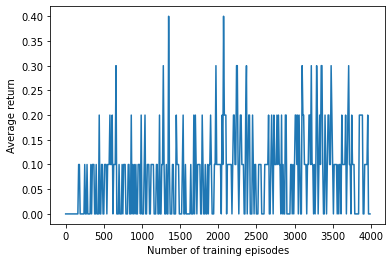

In [ ]:
run_q_learning_experiment(
    0.05, 0.9, 0.9, 0.7, 500, 1, 1000, np_to_hash_with_potential_pits, 4000
)

In [ ]:
print_agent_n_learned_states(agent)

Number of states where the learned Q-function is nonzero: 574
Number of possible states:                                5577


Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.2
	360	|	0.0
	370	|	0.1
	380	|	0.0
	390	|	0.0
	400	|	0.1
	410	|	0.1
	420	|	0.0
	430	|	0.0
	440	|	0.0
	450	|	0.1
	460	|	0.0
	470	|	0.1
	480	|	0.0
	490	|	0.0
	500	|	0.2
	510	|	0.1
	520	|	0.0
	530	|	0.0
	540	|	0.0
	550	|	0.1
	560	|	0.2
	570	|	0.3
	580	|	0.1
	590	|	0.1
	600	|	0.0
	610	|	0.0
	620	|	0.0
	630	|	0.1
	640	|	0.1
	650	|	0.0
	660	|	0.3
	670	|	0.1
	680	|	0.1
	690	|	0.0
	700	|	0.0
	710	|	0.1
	720	|	0.1
	730	|	0.0
	740	|	0.1
	750	|	0.0
	760	|	0.0
	770	|	0.0
	780	|	0.1
	790	|	0.0
	800	|	0.1
	810	|	0.1


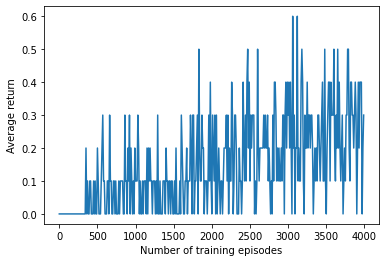

In [ ]:
run_q_learning_experiment(
    0.05, 0.9, 0.9, 0.7, 1000, 1, 1000, np_to_hash_with_potential_pits, 4000, 10000
)

In [ ]:
print_agent_n_learned_states(agent)

Number of states where the learned Q-function is nonzero: 1197
Number of possible states:                                6706


### Final experiment with the optimal parameters

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.1
	80	|	0.1
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.1
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.1
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.1
	210	|	0.0
	220	|	0.1
	230	|	0.1
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.1
	330	|	0.0
	340	|	0.1
	350	|	0.1
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.2
	420	|	0.1
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.1
	470	|	0.0
	480	|	0.0
	490	|	0.0
	500	|	0.1
	510	|	0.0
	520	|	0.0
	530	|	0.2
	540	|	0.0
	550	|	0.0
	560	|	0.0
	570	|	0.0
	580	|	0.0
	590	|	0.0
	600	|	0.2
	610	|	0.1
	620	|	0.1
	630	|	0.0
	640	|	0.1
	650	|	0.1
	660	|	0.0
	670	|	0.1
	680	|	0.0
	690	|	0.1
	700	|	0.2
	710	|	0.2
	720	|	0.4
	730	|	0.3
	740	|	0.0
	750	|	0.1
	760	|	0.0
	770	|	0.0
	780	|	0.1
	790	|	0.1
	800	|	0.1
	810	|	0.2


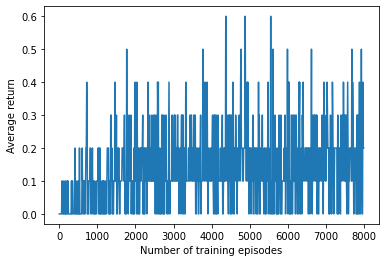

In [ ]:
%%time

optimal_parameters_big_maze = {
    "alpha": 0.05,
    "epsilon": 0.9,
    "gamma": 0.9,
    "lambd": 0.7,
    "update_eps_every_N": 1000,
    "update_alpha_every_N": 2000,
    "max_steps": 10000,
    "num_episodes": 8000,
    "maze_template": BIG_MAZE,
    "hash_function": np_to_hash_with_potential_pits,
}

agent_bm, environment_bm, rewards_bm = run_q_learning_experiment(
    **optimal_parameters_big_maze
)

In [ ]:
rewards_bm = validate_model(
    agent_bm,
    environment_bm,
    max_steps=optimal_parameters_big_maze["max_steps"],
    n_trials=1000,
)


Mean reward over 1000 trials: 0.54, std: 0.87
Function validate_model took 1.78 seconds



In [ ]:
print_agent_n_learned_states(agent_bm)

Number of states where the learned Q-function is nonzero: 812
Number of possible states:                                5994


# **[Exercice 2]** Implementing a deep RL Algorithm.

Your second (harder) task is to implement a _Deep RL algorithm_ for the maze environment. You can go for either DQN or a variant of policy gradient of your choice. Again, feel free to take inspiration from the other practicals.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- ` def first_observe(self, state: chex.Array) -> None:` a function that takes care of handling the first observation obtained after a reset. This function can notably memorize the first state, so that when we call observe, we have a full transition `(state, action, reward, done, next_state)` at our disposal.
- `def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:` a function that takes an action, a reward, a termination signal and a next state, and performs any update required by our agent to update its policy. To make things much easier, you should look at what this function is doing for the implementation in the DQN practical.

In [ ]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp

In [ ]:
# @title **[Implement]** Uniform Replay Buffer { form-width: "30%" }

import dataclasses


@chex.dataclass
class Transition:
    state_t: chex.Array
    action_t: chex.Array
    reward_t: chex.Array
    done_t: chex.Array
    state_tp1: chex.Array


class ReplayBuffer:
    """Fixed-size buffer to store transition tuples."""

    def __init__(self, buffer_capacity: int):
        """Initialize a ReplayBuffer object.
        Args:
            buffer_capacity (int): maximal number of tuples to store at once
        """
        self._memory = list()
        self._maxlen = buffer_capacity

    @property
    def size(self) -> int:
        # Return the current number of elements in the buffer.
        return len(self._memory)

    def add(
        self,
        state_t: chex.Array,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> None:
        """Add a new transition to memory."""

        if self.size > self._maxlen:
            self._memory = self._memory[1:]

        self._memory.append(
            Transition(
                state_t=state_t,
                action_t=action_t,
                reward_t=reward_t,
                done_t=done_t,
                state_tp1=state_tp1,
            )
        )

    def sample(self) -> Transition:
        """Randomly sample a transition from memory."""
        assert self._memory, "replay buffer is unfilled"

        index = np.random.randint(self.size)
        return self._memory[index]

In [ ]:
# @title **[Implement]** Batched Replay Buffer { form-width: "30%" }


class BatchedReplayBuffer(ReplayBuffer):
    def sample_batch(self, batch_size) -> Transition:
        """Randomly sample a batch of experiences from memory."""
        assert (
            len(self._memory) >= batch_size
        ), "Insuficient number of transitions in replay buffer"

        samples = [self.sample() for i in range(batch_size)]
        kwargs = dict()
        for attr in ["state_t", "action_t", "reward_t", "done_t", "state_tp1"]:
            kwargs[attr] = np.array([getattr(s, attr) for s in samples])
        return Transition(**kwargs)

### Network architecture

In [ ]:
# @title MLP


def network_flat(x: chex.Array, n_actions: int, layer_size: int) -> chex.Array:
    x_flat = hk.Flatten()(x)
    output = hk.nets.MLP(output_sizes=[layer_size, n_actions])(x_flat)
    return output

In [ ]:
# @title Convolutional network


def network_conv(
    x: chex.Array, n_actions: int, conv_sizes: chex.Array, mlp_size: int
) -> chex.Array:
    convs = []
    for layer_size in conv_sizes:
        convs.append(
            hk.Conv2D(layer_size, kernel_shape=[3, 3], stride=2, padding="SAME")
        )
        convs.append(jax.nn.relu)

    dense = [hk.Flatten(), hk.nets.MLP([mlp_size, n_actions])]

    model = hk.Sequential(convs + dense)
    return model(x)

### DQN agent

In [ ]:
@chex.dataclass
class LearnerState:
    online_params: hk.Params
    target_params: hk.Params
    opt_state: optax.OptState


class DQNAgent:
    def __init__(
        self,
        env: Maze,
        gamma: float,
        eps: float,
        learning_rate: float,
        buffer_capacity: int,
        min_buffer_capacity: int,
        batch_size: int,
        target_ema: float,
        network,
        seed: int = 0,
    ) -> None:
        """Initializes the DQN agent.

        Args:
          env: input catch environment.
          gamma: discount factor
          eps: probability to perform a random exploration when picking a new action.
          learning_rate: learning rate of the online network
          buffer_capacity: capacity of the replay buffer
          min_buffer_capacity: min buffer size before picking batches from the
            replay buffer to update the online network
          batch_size: batch size when updating the online network
          target_ema: weight when updating the target network.
          seed: seed of the random generator.
        """
        self._env = env
        self._learning_rate = learning_rate
        self.network = network

        self._eps = eps
        self._gamma = gamma
        self._batch_size = batch_size
        self._target_ema = target_ema
        self._Na = env.num_actions()

        # Define the neural network for this agent
        self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
        # Jit the forward pass of the neural network for better performances
        self.apply = jax.jit(self._apply)

        # Also jit the update functiom
        self._update_fn = jax.jit(self._update_fn)

        # Initialize the network's parameters
        self._rng = jax.random.PRNGKey(seed)
        self._rng, init_rng = jax.random.split(self._rng)
        self._learner_state = self._init_state(init_rng)

        # Initialize the replay buffer
        self._min_buffer_capacity = min_buffer_capacity
        self._buffer = BatchedReplayBuffer(buffer_capacity)

        # Build a variable to store the last state observed by the agent
        self._state = None

    def _optimizer(self) -> optax.GradientTransformation:
        return optax.adam(learning_rate=self._learning_rate)

    def _hk_qfunction(self, state: chex.Array) -> chex.Array:
        return self.network(state, self._Na)

    def first_observe(self, state: chex.Array) -> None:
        self._state = state

    def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
        """Initialize the online parameters, the target parameters and the
        optimizer's state."""
        dummy_step = 1.0 * self._env.reset()[None]

        online_params = self._init(rng, dummy_step)
        target_params = online_params
        opt_state = self._optimizer().init(online_params)

        return LearnerState(
            online_params=online_params,
            target_params=target_params,
            opt_state=opt_state,
        )

    @property
    def learner_state(self):
        return self._learner_state

    @learner_state.setter
    def learner_state(self, value):
        print("Loading model state dict..")
        self._learner_state = value

    def act(
        self,
        state: chex.Array,
        eval: bool,
    ) -> chex.Array:
        """Picks the next action using an epsilon greedy policy.

        Args:
          state: observed state.
          eval: if True the agent is acting in evaluation mode (which means it only
            acts according to the best policy it knows.)
        """
        if not eval and np.random.uniform() < self._eps:
            return np.random.randint(self._Na)
        return np.argmax(self._apply(self._learner_state.online_params, state[None]))

    def loss_fn(
        self,
        online_params: hk.Params,
        target_params: hk.Params,
        state_t: chex.Array,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> chex.Array:
        """Computes the Q-learning loss

        Args:
          online_params: parameters of the online network
          target_params: parameters of the target network
          state_t: batch of observations at time t
          action_t: batch of actions performed at time t
          reward_t: batch of rewards obtained at time t
          done_t: batch of end of episode status at time t
          state_tp1: batch of states at time t+1
        Returns:
          The Q-learning loss.
        """
        # Step one: compute the target Q-value for state t+1
        q_tp1 = self._apply(target_params, state_tp1)

        # We do not want to consider the Q-value of states that are done !
        # For theses states, q(t+1) = 0
        q_tp1 = (1.0 - done_t[..., None]) * q_tp1

        # Now deduce the value of the target cumulative reward
        y_t = reward_t + self._gamma * jnp.max(q_tp1, axis=1)  # Shape B

        # Compute the online Q-value for state t
        q_t = self._apply(online_params, state_t)  # Shape B , Na

        # Ok, but we only want the Q value for the actions that have actually
        # been played
        q_at = jax.vmap(lambda idx, q: q[idx])(action_t, q_t)

        # Compute the square error
        error = (q_at - y_t) ** 2

        # Deduce the loss
        return jnp.mean(error)

    def _update_fn(
        self,
        state: LearnerState,
        batch: Transition,
    ) -> Tuple[chex.Array, LearnerState]:
        """Get the next learner state given the current batch of transitions.

        Args:
          state: learner state before update.
          batch: batch of experiences (st, at, rt, done_t, stp1)
        Returns:
          loss, learner state after update
        """

        # Compute gradients
        loss, gradients = jax.value_and_grad(self.loss_fn)(
            state.online_params,
            state.target_params,
            batch.state_t,
            batch.action_t,
            batch.reward_t,
            batch.done_t,
            batch.state_tp1,
        )

        # Apply gradients
        updates, new_opt_state = self._optimizer().update(gradients, state.opt_state)
        new_online_params = optax.apply_updates(state.online_params, updates)

        # Update target network params as:
        # target_params <- ema * target_params + (1 - ema) * online_params
        new_target_params = jax.tree_map(
            lambda x, y: x + (1 - self._target_ema) * (y - x),
            state.target_params,
            new_online_params,
        )
        return loss, LearnerState(
            online_params=new_online_params,
            target_params=new_target_params,
            opt_state=new_opt_state,
        )

    def observe(
        self,
        action_t: chex.Array,
        reward_t: chex.Array,
        done_t: chex.Array,
        state_tp1: chex.Array,
    ) -> chex.Array:
        """Updates the agent from the given observations.

        Args:
          action_t: action performed at time t.
          reward_t: reward obtained after having performed action_t.
          done_t: whether or not the episode is over after performing action_t.
          state_tp1: state at which the environment is at time t+1.
        Returns:
          DQN loss obtained when updating the online network.
        """
        # First, we need to add the new transition to the memory buffer
        self._buffer.add(self._state, action_t, reward_t, done_t, state_tp1)
        self._state = state_tp1

        # We update the agent if and only if we have enought state stored in
        # memory.
        if self._buffer.size >= self._min_buffer_capacity:
            batch = self._buffer.sample_batch(self._batch_size)
            loss, self._learner_state = self._update_fn(self._learner_state, batch)
            return loss
        return 0.0

### Utility functions to run the experiments

In [ ]:
def run_dqn_episode(
    deep_agent: DQNAgent, env: Maze, eval: bool, max_steps: int = 1000
) -> float:
    # Reset any counts and start the environment.
    state = env.reset().copy()
    deep_agent.first_observe(state)
    num_steps = 0

    # Run an episode.
    while True:

        # Generate an action from the agent's policy and step the environment.
        action = deep_agent.act(1.0 * state, eval)
        next_state, reward, done = env.step(action)

        # Update
        if not eval:
            deep_agent.observe(action, reward, done, 1.0 * next_state.copy())

        num_steps += 1
        state = 1.0 * next_state.copy()
        if done or num_steps > max_steps:
            break

    return reward

In [ ]:
def run_dqn_experiment(
    agent: DQNAgent,
    num_episodes: int = 1000,
    num_eval_episodes: int = 3,
    eval_every_N: int = 20,
    evaluation_start: int = 0,
) -> Tuple[List[int], List[float]]:
    print(
        f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes:\t| Training time"
    )
    print("------------------------------------------------------")
    episodes, all_rewards = [], []
    episode_start = time.time()

    for episode in range(num_episodes):
        run_dqn_episode(deep_agent, env, eval=False)

        if episode % eval_every_N == 0:
            episode_length = np.round(time.time() - episode_start, 2)

            # only recording the results for episodes that come after some training
            if episode >= evaluation_start:
                reward = np.mean(
                    [
                        run_dqn_episode(deep_agent, env, eval=True)
                        for _ in range(num_eval_episodes)
                    ]
                )
                print(f"\t{episode}\t|\t{reward}|\t{episode_length}s")
                all_rewards.append(reward)
                episodes.append(episode)
            else:
                print(f"\t{episode}\t|\t{episode_length}s")

            episode_start = time.time()

    plt.xlabel("Number of training episodes")
    plt.ylabel("Average return")
    plt.plot(episodes, all_rewards)

    return episodes, all_rewards

### Experiments

In [ ]:
env = Maze(TXT_TEMPLATE)

conv_sizes = [8, 16, 32]
mlp_size = 128

print(
    f"Training DeepQ conv Network with layer sizes {str(conv_sizes)} + [{str(mlp_size)}]"
)

deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.7,
    learning_rate=3e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
    network=lambda x, y: network_conv(x, y, conv_sizes, mlp_size),
)

run_dqn_experiment(deep_agent, evaluation_start=800)

#### Cross validation on the architectures

In [ ]:
num_episodes = 1000
num_eval_episodes = 100
display_every_N = 100

for layer_sizes in [
    [16, 32, 128]
]:  # [32], [64], [128], [4, 8, 32], [4, 8, 64], [4, 8, 128], [16, 32, 64], [16, 32, 128]]:

    conv_sizes = layer_sizes[:-1]
    mlp_size = layer_sizes[-1]

    print(
        f"Training DeepQ conv Network with layer sizes {str(conv_sizes)} + [{str(mlp_size)}]"
    )
    start = time.time()

    deep_agent = DQNAgent(
        env=env,
        gamma=0.9,
        eps=0.7,
        learning_rate=3e-4,
        buffer_capacity=2500,
        min_buffer_capacity=64,
        batch_size=32,
        target_ema=0.9,
        network=lambda x, y: network_conv(x, y, conv_sizes, mlp_size),
    )

    print(
        f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes:\t| Training time"
    )
    print("------------------------------------------------------")

    # training
    for episode in range(num_episodes):
        run_dqn_episode(deep_agent, env, eval=False)
        if episode % display_every_N == 0:
            print(f"\t{episode}\t")

    training_time = time.time() - start
    print(f"The training took {training_time:.2f} s")

    # evaluation
    print("Evaluation on 100 runs ...")
    rewards = [run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)]
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(
        f"Architecture: {str(conv_sizes)} + [{str(mlp_size)}], result: {mean_reward} +/- { 1.96 * std_reward / 10.}"
    )

#### Hyperparameters tuning

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.3,
    learning_rate=3e-4,
    buffer_capacity=1000,
    min_buffer_capacity=32,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)


Episode number:	| Average reward on 3 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.6666666666666666
	50	|	0.3333333333333333
	60	|	0.3333333333333333
	70	|	0.3333333333333333
	80	|	0.6666666666666666
	90	|	0.0
	100	|	0.3333333333333333
	110	|	0.3333333333333333
	120	|	0.6666666666666666
	130	|	0.3333333333333333
	140	|	0.6666666666666666
	150	|	1.0
	160	|	0.6666666666666666
	170	|	0.3333333333333333
	180	|	1.0
	190	|	0.3333333333333333
	200	|	0.6666666666666666
	210	|	1.0
	220	|	0.6666666666666666
	230	|	0.6666666666666666
	240	|	1.0
	250	|	1.0
	260	|	1.0
	270	|	1.0
	280	|	1.0
	290	|	1.0
	300	|	1.0
	310	|	1.0
	320	|	0.6666666666666666
	330	|	1.0
	340	|	1.0
	350	|	0.6666666666666666
	360	|	0.6666666666666666
	370	|	1.0
	380	|	0.6666666666666666
	390	|	1.0
	400	|	1.0
	410	|	1.0
	420	|	0.3333333333333333
	430	|	1.0
	440	|	1.0
	450	|	1.0
	460	|	0.6666666666666666
	470	|	1.0
	480	|	1.0
	490	|	1.0
	500	|	1.0
	510	|	1.0
	

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.7,
    eps=0.3,
    learning_rate=3e-4,
    buffer_capacity=1000,
    min_buffer_capacity=32,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.99,
    eps=0.3,
    learning_rate=3e-4,
    buffer_capacity=1000,
    min_buffer_capacity=32,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.5,
    learning_rate=3e-4,
    buffer_capacity=2000,
    min_buffer_capacity=32,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.7,
    learning_rate=3e-4,
    buffer_capacity=2000,
    min_buffer_capacity=32,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.7,
    learning_rate=3e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.7,
    learning_rate=9e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.9,
    eps=0.5,
    learning_rate=9e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)


Episode number:	| Average reward on 3 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.6666666666666666
	60	|	0.6666666666666666
	70	|	1.0
	80	|	1.0
	90	|	1.0
	100	|	1.0
	110	|	0.6666666666666666
	120	|	0.6666666666666666
	130	|	1.0
	140	|	1.0
	150	|	1.0
	160	|	1.0
	170	|	1.0
	180	|	1.0
	190	|	1.0
	200	|	1.0
	210	|	1.0
	220	|	1.0
	230	|	1.0
	240	|	1.0
	250	|	1.0
	260	|	1.0
	270	|	1.0
	280	|	1.0
	290	|	1.0
	300	|	1.0
	310	|	1.0
	320	|	1.0
	330	|	1.0
	340	|	1.0
	350	|	1.0
	360	|	1.0
	370	|	1.0
	380	|	1.0
	390	|	1.0
	400	|	1.0
	410	|	1.0
	420	|	1.0
	430	|	1.0
	440	|	1.0
	450	|	1.0
	460	|	1.0
	470	|	1.0
	480	|	1.0
	490	|	1.0
	500	|	1.0
	510	|	1.0
	520	|	1.0
	530	|	1.0
	540	|	1.0
	550	|	1.0
	560	|	1.0
	570	|	1.0
	580	|	1.0
	590	|	1.0
	600	|	1.0
	610	|	1.0
	620	|	1.0
	630	|	1.0
	640	|	1.0
	650	|	1.0
	660	|	1.0
	670	|	1.0
	680	|	1.0
	690	|	1.0
	700	|	1.0
	710	|	1.0
	720	|	1.0
	730	|	1.0
	740	|	1.0
	750	|	1.0
	760	|	

#### Checking the robustness of the results

In [1]:
num_episodes = 1000
num_eval_episodes = 100
display_every_N = 100

n_trials = 10 #@param {type:"slider", min:5, max:20, step:1}

for i in range(n_trials):

    conv_sizes = [16, 32]
    mlp_size = [128]

    print(
        f"Training DeepQ conv Network with layer sizes {str(conv_sizes)} + [{str(mlp_size)}] run {i}"
    )
    start = time.time()

    deep_agent = DQNAgent(
        env=env,
        gamma=0.9,
        eps=0.7,
        learning_rate=3e-4,
        buffer_capacity=2500,
        min_buffer_capacity=64,
        batch_size=32,
        target_ema=0.9,
        network=lambda x, y: network_conv(x, y, conv_sizes, mlp_size),
    )

    print(
        f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes:\t| Training time"
    )
    print("------------------------------------------------------")

    # training
    for episode in range(num_episodes):
        run_dqn_episode(deep_agent, env, eval=False)
        if episode % display_every_N == 0:
            print(f"\t{episode}\t")

    training_time = time.time() - start
    print(f"The training took {training_time:.2f} s")

    # evaluation
    print(f"Evaluation on {num_eval_episodes} runs ...")
    rewards = [run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)]
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    print(
        f"Architecture: {str(conv_sizes)} + [{str(mlp_size)}], result: {mean_reward} +/- { 1.96 * std_reward / np.sqrt(num_eval_episodes)}"
    )


Training DeepQ conv Network with layer sizes [16, 32]+[128] run 0
Episode number:	| Average reward on 0 eval episodes:	| Training time
------------------------------------------------------

/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
  
	0	
	100	
	200	
	300	
	400	
	500	
	600	
	700	
	800	
	900	
Evaluation on 100 runs ...
Architecture: [16, 32]+[128] 1.0 +/- 0.0
The training run 0 took 349.72s
Training DeepQ conv Network with layer sizes [16, 32]+[128] run 1
Episode number:	| Average reward on 0 eval episodes:	| Training time
------------------------------------------------------
	0	
	100	
	200	
	300	
	400	
	500	
	600	
	700	
	800	
	900	
Evalu

### Dealing with the bigger maze

In [ ]:
# @title Template for the big maze

BIG_MAZE = """
#########################################
#SSS#     #PPP#S#      #         #G   PP#
#   #GP       # #####  #P  #     #      #
#   ####  #   # #G     #   #GGGGGGGGG   #
#      GGG#   # #      #   ###########  #
###########         #      #            #
#G        #PP     GGGGGG#GG###S      GGG#
#PP  P#   ##################    #########
#######   #      #P                     #
#G               G      #S      P#      #
#########################################
---
S=0
G=0
P=0.5
"""

The hash function below was adapted for a batched use by DQN.
It is an attempt at reducing the size of the states in order to fasten the training process, however it did not yield any significant result.

In [ ]:
# @title Updated hash function


def np_to_hash_net(state: chex.Array) -> chex.Array:
    ALL_PITS = process_template(BIG_MAZE)[0][..., 3]
    P0, P1 = jnp.nonzero(ALL_PITS)

    HASHED_PITS = []
    for i in range(len(P0)):
        HASHED_PITS.append(P0[i].astype("float32"))
        HASHED_PITS.append(P1[i].astype("float32"))

    def hash_batch(batch):
        s0, s1 = jnp.unravel_index(jnp.argmax(batch[..., 1]), batch[..., 1].shape)
        g0, g1 = jnp.unravel_index(jnp.argmax(batch[..., 2]), batch[..., 2].shape)
        hashed_s_g = [
            s0.astype("float32"),
            s1.astype("float32"),
            g0.astype("float32"),
            g1.astype("float32"),
        ]
        hashed_state = hashed_s_g + HASHED_PITS
        return jnp.array(hashed_state)

    out = jax.vmap(hash_batch)(state)
    return out

In [ ]:
# @title Updated function for running an episode


def run_dqn_episode(
    deep_agent: DQNAgent,
    env: Maze,
    eval: bool,
    max_steps: int = 1000,
    verbose: bool = False,
    render_states: bool = False,
) -> float:
    """
    Updated version of the previous function run_dqn_episode with more verbose to help debugging.
    """
    # Reset any counts and start the environment.
    state = env.reset().copy()
    deep_agent.first_observe(state)
    num_steps = 0

    # Run an episode.
    while True:

        if eval and render_states:
            print(env.render())
            print("")

        # Generate an action from the agent's policy and step the environment.
        action = deep_agent.act(1.0 * state, eval)

        next_state, reward, done = env.step(action)
        if not eval:
            deep_agent.observe(action, reward, done, 1.0 * next_state.copy())
        num_steps += 1

        # early stopping when the agent get stuck (no randomness during evaluation)
        if eval and num_steps > 10 and (1.0 * state == 1.0 * next_state).all():
            break

        if done:
            if verbose:
                print(f"Stopping after {num_steps} steps, ", end="")
                if reward > 0:
                    print("found the goal.")
                elif reward < 0:
                    print("fell into a pit.")
            break
        elif num_steps > max_steps:
            if verbose:
                print("Max number of steps reached")
            break

        state = 1.0 * next_state.copy()

    return reward

In [ ]:
env = Maze(BIG_MAZE)

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.99,
    eps=0.3,
    learning_rate=3e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)


Episode number:	| Average reward on 3 eval episodes
------------------------------------------------------
Fell into a pit.
Max number of steps reached
Max number of steps reached
Max number of steps reached
	0	|	0.0
Found the goal.
Found the goal.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Found the goal.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Max number of steps reached
Max number of steps reached
Max number of steps reached
	10	|	0.0
Found the goal.
Fell into a pit.
Fell into a pit.
Found the goal.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Max number of steps reached
Found the goal.
Max number of steps reached
Max number of steps reached
Max number of steps reached
	20	|	0.0
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Fell into a pit.
Max number of steps reached
Max number of steps reached
Max number of steps rea

To adapt the agent to a bigger environment we increased the values of $\epsilon$ to encourage exploration and $\gamma$ to account for a more distant future. We observe that even though the agent explores well during the training (it always reaches either a pit or a goal), in evaluation it never receives a reward.

In [ ]:
deep_agent = DQNAgent(
    env=env,
    gamma=0.99,
    eps=0.7,
    learning_rate=3e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent)


Episode number:	| Average reward on 3 eval episodes
------------------------------------------------------
Stopping after 1044 steps, found the goal.

New episode
#########################################
#   #     # PP# #      #         #    PP#
#   #         # #####  #   #     #      #
#   ####  #   # #      #   #            #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ###         G#
#P   P#   ##################    #########
#######   #      #                      #
#                       #S       #      #
#########################################

#########################################
#   #     # PP# #      #         #    PP#
#   #         # #####  #   #     #      #
#   ####  #   # #      #   #            #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ###         G#
#P   P#   ##################    #########
#######   #      #                   

By adding more verbosity we can now understand that during evaluation the agent often gets stuck because there is no randomness in his actions then.

#### Training on mazes of increasing complexity

The mazes below will be used to train the agent iteratively.

In [ ]:
# @title Mazes definition

BASIC_MAZE = """
#########################################
#SSS           S                  G     #
#    G                                  #
#                G          GGGGGGGGG   #
#      GGG                              #
#                                       #
#G                GGGGGG GG   S      GGG#
#                                       #
#                                       #
#G               G       S              #
#########################################
---
S=0
G=0
P=0.5
"""


MAZES = [
    """
    #########################################
    #SSS           S                  G     #
    #               #####                   #
    #               G          GGGGGGGGG    #
    #      GGG                 #######      #
    ##########                              #
    #G                GGGGGG GG   S      GGG#
    #         #################     #########
    #                                       #
    #G               G        S             #
    #########################################
    ---
    S=0
    G=0
    P=0.5
    """,
    """
    #########################################
    #SSS#          S                  G     #
    #               #####                   #
    #               G          GGGGGGGGG    #
    #      GGG                 #######      #
    ##########                              #
    #G                GGGGGG GG   S      GGG#
    #         ##################    #########
    #                                       #
    #G               G      #S             #
    #########################################
    ---
    S=0
    G=0
    P=0.5
    """,
    """
    #########################################
    #SSS#         #S#      #         #G     #
    #   #G        # #      #   #            #
    #   #     #   # #G     #   #GGGGGGGGG   #
    #      GGG#   # #      #   ########     #
    ###########                #            #
    #G        #       GGGGGG#GG#  S      GGG#
    #         ##################      #######
    ######           #                      #
    #G               G      #S              #
    #########################################
    ---
    S=0
    G=0
    P=0.01
    """,
    # almost 0 pit
    """
    #########################################
    #SSS#     #PPP#S#      #         #G   PP#
    #   #GP       # #####  #P  #     #      #
    #   ####  #   # #G     #   #GGGGGGGGG   #
    #      GGG#   # #      #   ###########  #
    ###########         #      #            #
    #G        #PP     GGGGGG#GG###S      GGG#
    #PP  P#   ##################    #########
    #######   #      #P                     #
    #G               G      #S      P#      #
    #########################################
    ---
    S=0
    G=0
    P=0.05
    """,
    # a few pits
    """
    #########################################
    #SSS#     #PPP#S#      #         #G   PP#
    #   #GP       # #####  #P  #     #      #
    #   ####  #   # #G     #   #GGGGGGGGG   #
    #      GGG#   # #      #   ###########  #
    ###########         #      #            #
    #G        #PP     GGGGGG#GG###S      GGG#
    #PP  P#   ##################    #########
    #######   #      #P                     #
    #G               G      #S      P#      #
    #########################################
    ---
    S=0
    G=0
    P=0.1
    """,
    # helper checkpoints
    """
    #########################################
    #SSS#     #PPP#S#      #   G     #G   PP#
    #   #GP   G   # #####  #P  #     #      #
    #   ####  #   # #G     #   #GGGGGGGGG   #
    # G    GGG#G  # #      #   ###########  #
    ###########    G    #      #   G        #
    #G    G   #PP     GGGGGG#GG###S      GGG#
    #PP  P#   ##################G   #########
    ####### G #      #P     G               #
    #G      G G      G      #S      P#      #
    #########################################
    ---
    S=0
    G=0
    P=0.5
    """,
    """
    #########################################
    #SSS#     #PPP#S#      #         #G   PP#
    #   #GP       # #####  #P  #     #      #
    #   ####  #   # #G     #   #GGGGGGGGG   #
    #      GGG#   # #      #   ###########  #
    ###########         #      #            #
    #G        #PP     GGGGGG#GG###S      GGG#
    #PP  P#   ##################    #########
    #######   #      #P                     #
    #G               G      #S      P#      #
    #########################################
    ---
    S=0
    G=0
    P=0.5
    """,
]

In [ ]:
#@title Learning on the simplest maze

env = Maze(BASIC_MAZE)
deep_agent = DQNAgent(
    env=env,
    gamma=0.99,
    eps=0.7,
    learning_rate=3e-4,
    buffer_capacity=2500,
    min_buffer_capacity=64,
    batch_size=32,
    target_ema=0.9,
)
run_dqn_experiment(deep_agent, num_episodes=500, eval_every_N=20)

In [ ]:
#@title Learning on mazes of increasing complexity

for i, maze_str in enumerate(MAZES):
    # saving the model's weights
    learner_state = deep_agent.learner_state

    print(f"Training the agent on maze number {i + 1}.")
    env = Maze(BASIC_MAZE)
    deep_agent = DQNAgent(
        env=env,
        gamma=0.99,
        eps=0.5,
        learning_rate=3e-4,
        buffer_capacity=2500,
        min_buffer_capacity=64,
        batch_size=32,
        target_ema=0.9,
    )

    # loading the previous model's weights
    deep_agent.learner_state = learner_state

    run_dqn_experiment(deep_agent, num_episodes=500, eval_every_N=20)